---
title: "Practical Deep Learning, Lesson 2, Rowing Classifier"
date: "2024-09-26"
tags:
- course.fast.ai
draft: false
series: "Fast.ai Course"
toc: true
github_url: https://github.com/danielcorin/fastbook_projects/tree/main/rowing_classifier
---


The following is the notebook I used to experiment training an image model to classify types of rowing shells (with people rowing them) and the same dataset by rowing technique (sweep vs. scull).
There are a few cells that output a batch of the data.
I decided not to include these because the rowers in these images didn't ask to be on my website.
I'll keep this in mind when selecting future datasets as I think showing the data batches in the notebook/post is helpful for understanding what is going on.

## Process

First, we install and import the `fastai` dependencies we'll need

In [ ]:
!pip install fastai

In [1]:
from fastcore.all import *
from fastai.vision.all import *

Next, we'll query DuckDuckGo to find images of all (most) of the different racing shell types.
This code can safely be run multiple times without overwriting the output folders.
E.g. if you want to run a query for a single type again, you can delete that folder and re-run the whole loop below.

In [5]:
def search_images(term, max_images=200):
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    headers = dict( referer='https://duckduckgo.com/' )
    urls,data = set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        res = urlread(requestUrl, data=params, headers=headers)
        data = json.loads(res) if res else {}
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

In [104]:
types = '8+ eight', '4+ four', '4x quad', '2- pair', '2x double', '1x single'
path = Path('boat_images')

In [ ]:
if not path.exists():
    path.mkdir()

for o in types:
    dest = (path/o)
    if not dest.exists() or len(list(dest.iterdir())) == 0:
        dest.mkdir(exist_ok=True)
        results = search_images(f'{o} rowing')
        download_images(dest, urls=results)
    else:
        print(f"Skipping download for {o}, folder already exists and contains images.")

Clean up any bad images we that won't be able to use to train the model.
I also manually classified the images into the appropriate folders to fix any confusion in the search.
There were a fair amount of issues here and many images needed to be thrown out as they weren't of boats.

In [106]:
for subfolder in path.iterdir():
    if subfolder.is_dir():
        print(subfolder)
        fns = get_image_files(subfolder)
        failed = verify_images(fns)
        print(failed)
        failed.map(Path.unlink)

boat_images/1x single
[]
boat_images/2- pair
[]
boat_images/4x quad
[]
boat_images/8+ eight
[]
boat_images/4+ four
[]
boat_images/2x double
[]


Output the counts of each boat type

In [107]:
path = Path('boat_images')

for subfolder in path.iterdir():
    if subfolder.is_dir():
        image_count = len([f for f in subfolder.glob('*') if f.is_file() and f.suffix.lower() in ('.png', '.jpg', '.jpeg', '.gif')])
        print(f"{subfolder.name}: {image_count} images")


1x single: 122 images
2- pair: 96 images
4x quad: 130 images
8+ eight: 143 images
4+ four: 94 images
2x double: 98 images


Load the data, apply transforms and train the model

In [ ]:
rowing = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(256))
dls = rowing.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

In [109]:
custom_aug_transforms = [
    RandomResizedCrop(256, min_scale=0.5),
    Flip(),
    Brightness(),
    Contrast(),
    Rotate(max_deg=10.0),
]
rowing = rowing.new(
    item_tfms=RandomResizedCrop(256, min_scale=0.5),
    batch_tfms=custom_aug_transforms,
)
dls = rowing.dataloaders(path)

In [110]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.868610,1.974037,0.693431,00:08


epoch,train_loss,valid_loss,error_rate,time
0,1.960591,1.450697,0.510949,00:09
1,1.707455,1.240547,0.445255,00:09
2,1.481500,1.168520,0.386861,00:09
3,1.332181,1.160436,0.416058,00:09


View the confusion matrix and top losses to get a sense of what types of images the model incorrectly classified

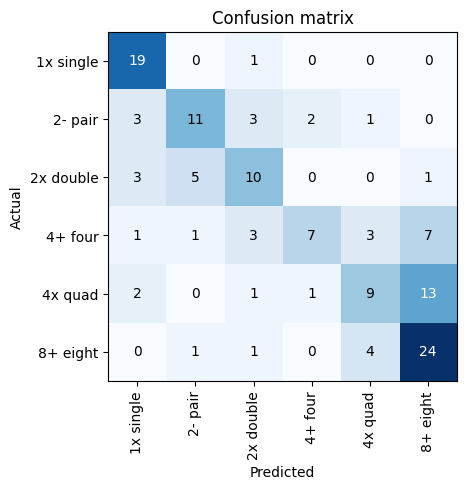

In [112]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(9, nrows=3)

Export the model to be run on Huggingface Spaces with `gradio`

In [84]:
learn.export('boat_export.pkl')

Now, using the same boat photos, we can split the dataset differently by photos of sweep and sculling boats.
Eight (8+), fours (4+) and pairs (2-) are sweep boats.
Quads (4x), doubles (2x) and single (1x) are sculling boats.

In [114]:
import shutil
from pathlib import Path

# Define source and destination paths
source_path = Path('boat_images')
dest_path = Path('sweep_scull_images')

# Create destination directories if they don't exist
(dest_path / 'sweep').mkdir(parents=True, exist_ok=True)
(dest_path / 'scull').mkdir(parents=True, exist_ok=True)

# Iterate through the source directory
for folder in source_path.iterdir():
    if folder.is_dir():
        # Determine if it's sweep or scull based on folder name
        if '+' in folder.name or '-' in folder.name:
            target = dest_path / 'sweep'
        elif 'x' in folder.name:
            target = dest_path / 'scull'
        else:
            continue  # Skip folders that don't match the criteria

        # Move images from the source folder to the appropriate destination
        for img in folder.glob('*'):
            shutil.copy2(img, target / img.name)

Using a similar approach, train the model and view the confusion matrix and top losses

In [ ]:
path = Path('sweep_scull_images')
custom_aug_transforms = [
    RandomResizedCrop(256, min_scale=0.5), Flip(), Brightness(), Contrast(), Rotate(max_deg=10.0)]

rowing = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(256, min_scale=0.5),
    batch_tfms=custom_aug_transforms)
dls = rowing.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

In [116]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.204057,0.888658,0.375000,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.912763,0.602911,0.272059,00:08
1,0.821069,0.576992,0.250000,00:08
2,0.707999,0.551489,0.220588,00:08
3,0.625944,0.532234,0.220588,00:08


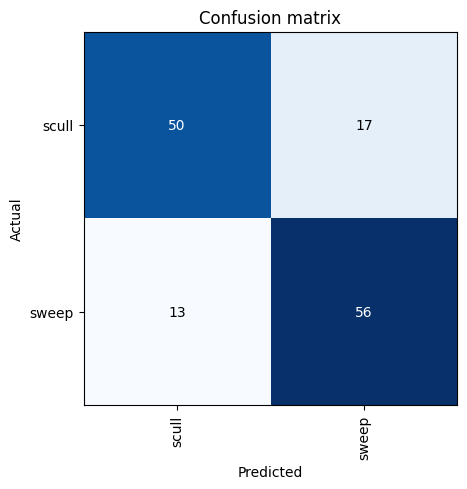

In [117]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(10, nrows=2)

The sweep/scull comparison performs better with an `error_rate` of 0.220588 compared to the boat classifier's 0.416058.
There was no obvious pattern in the top losses.

A final thought I had was to train two more models (one on sweep boats and the other on sculled boats).
Then I could try and first classify the rowing technique then the boat type, but I'm not quite sure whether it would be realistic to expect improvement with this approach given the compounding error rate.

## Dataset

For those very familiar with rowing, I didn't distinguish between a "coxless" or "straight 4" (4-) and a coxed-4 (4+).
Additionally, there are notably few images of pairs and fours as seen by the print out above.
My first data set contained the following counts per boat type:

- 1x single: 149 images
- 2- pair: 76 images
- 4x quad: 134 images
- 8+ eight: 153 images
- 4+ four: 66 images
- 2x double: 108 images

The model results for this weren't great.
I tried rounding out the dataset a bit by manually curating more pair and four photos so that the dataset was more evenly distributed.

- 1x single: 149 images
- 2- pair: 100 images
- 4x quad: 134 images
- 8+ eight: 153 images
- 4+ four: 100 images
- 2x double: 108 images

This additional data didn't seem to make a meaningful improvement in the error_rates for the boat classifier or the sweep vs. scull classifier.

## Results

The confusion matrices and top losses were interesting.
For the boat type classifier, the model sometimes had difficulty distinguishing the difference between boats with the same number of people and boats with the same number of oars.
To that end, pairs and quads had the most confusion between multiple other boat types.
A pair has two oars like a single and two people like a double.
A quad has eight oars like an 8 and four people like a 4.
There was a fair amount of confusion between 4s and 8s as well.

There were also a few cartoon renderings of just boats -- some of these had high loss.
Also, pictures with multiple boats in the image or very zoomed out were problematic.
There weren't as many of these in the training set so better sampling might help with that.

Applying `RandomResizedCrop` seemed to create some variability in the training process.
Maybe there's a way to make this behavior consistent with a random seed -- I am not sure.
Finally, looking at the top losses, I decided to remove all cartoon photos and photos of empty boats to try and reduce the scope of the problem.
Manually curating the images once more left me with the following totals:

- 1x single: 122 images
- 2- pair: 96 images
- 4x quad: 130 images
- 8+ eight: 143 images
- 4+ four: 94 images
- 2x double: 98 images

This resulted in the lowest error rate so far for the boat classifier around 0.4.
The top losses were images with multiple boats and a spattering of other things.
It was hard to identify any one specific issue, so it made sense to stop here.